In [1]:
%matplotlib inline
%load_ext line_profiler
from __future__ import print_function, division

from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, ReflectivityFitFunction, CurveFitter, GlobalFitter, to_parameters
import refnx.analysis.reflect as reflect

import corner
from lmfit.printfuncs import fit_report
import numpy as np
from matplotlib.pyplot import *
import multiprocessing

In [2]:
#load the data
e361 = ReflectDataset('e361r.txt')
e365 = ReflectDataset('e365r.txt')
e366 = ReflectDataset('e366r.txt')

In [3]:
# These arrays describe the layered nature of the system.
layers361 = np.array([[0,   2.07, 0, 0],     # fronting medium
                   [30,  3.47, 0, 3],     # 1st layer
                   [250, 2.00, 0, 3],     # 2nd layer
                   [0,   6.36, 0, 3]])     # backing medium

varies361 = np.array([[False, False, False, False],     # fronting medium
                   [True, False, False, False],     # 1st layer
                   [True, True, False, False],     # 2nd layer
                   [False, False, False, True]])     # backing medium

lowlim361 = np.array([[0,   2.07, 0, 0],     # fronting medium
                   [1,  3.47, 0, 1],     # 1st layer
                   [200, 0.10, 0, 1],     # 2nd layer
                   [0,   6.36, 0, 1]])     # backing medium

hilim361 = np.array([[0,   2.07, 0, 0],     # fronting medium
                  [50,  3.47, 0, 9],     # 1st layer
                  [300, 3.00, 0, 9],     # 2nd layer
                  [0,   6.36, 0, 15]])     # backing medium

In [4]:
# These arrays describe the layered nature of the system.
layers365 = np.array([[0,   2.07, 0, 0],     # fronting medium
                   [30,  3.47, 0, 3],     # 1st layer
                   [250, 2.00, 0, 3],     # 2nd layer
                   [0,   4, 0, 3]])     # backing medium

varies365 = np.array([[False, False, False, False],     # fronting medium
                   [True, False, False, False],     # 1st layer
                   [True, True, False, False],     # 2nd layer
                   [False, True, False, True]])     # backing medium

lowlim365 = np.array([[0,   2.07, 0, 0],     # fronting medium
                   [1,  3.47, 0, 1],     # 1st layer
                   [200, 0.10, 0, 1],     # 2nd layer
                   [0,   3., 0, 1]])     # backing medium

hilim365 = np.array([[0,   2.07, 0, 0],     # fronting medium
                  [50,  3.47, 0, 9],     # 1st layer
                  [300, 3.00, 0, 9],     # 2nd layer
                  [0,   4, 0, 15]])     # backing medium

In [5]:
# These arrays describe the layered nature of the system.
layers366 = np.array([[0,   2.07, 0, 0],     # fronting medium
                   [30,  3.47, 0, 3],     # 1st layer
                   [250, 2.00, 0, 3],     # 2nd layer
                   [0,   -0.56, 0, 3]])     # backing medium

varies366 = np.array([[False, False, False, False],     # fronting medium
                   [True, False, False, False],     # 1st layer
                   [True, True, False, False],     # 2nd layer
                   [False, True, False, True]])     # backing medium

lowlim366 = np.array([[0,   2.07, 0, 0],     # fronting medium
                   [1,  3.47, 0, 1],     # 1st layer
                   [200, 0., 0, 1],     # 2nd layer
                   [0,   -0.56, 0, 1]])     # backing medium

hilim366 = np.array([[0,   2.07, 0, 0],     # fronting medium
                  [50,  3.47, 0, 9],     # 1st layer
                  [300, 3.00, 0, 9],     # 2nd layer
                  [0,  -0.56, 0, 15]])     # backing medium

In [6]:
# But we need these parameters in a 1D array. convert_layer_format_to_coefs does this.
coefs361 = reflect.layer_to_coefs(layers361, scale=1, bkg=3e-6)
varies361 = np.asarray(reflect.layer_to_coefs(varies361, scale=True, bkg=True), bool)
lowlim361 = reflect.layer_to_coefs(lowlim361, scale=0.6, bkg=0)
hilim361 = reflect.layer_to_coefs(hilim361, scale=1.2, bkg=9e-5)

bounds361 = zip(lowlim361, hilim361)

coefs365 = reflect.layer_to_coefs(layers365, scale=1, bkg=3e-6)
varies365 = np.asarray(reflect.layer_to_coefs(varies365, scale=True, bkg=True), bool)
lowlim365 = reflect.layer_to_coefs(lowlim365, scale=0.6, bkg=0)
hilim365 = reflect.layer_to_coefs(hilim365, scale=1.2, bkg=9e-5)

bounds365 = zip(lowlim365, hilim365)

coefs366 = reflect.layer_to_coefs(layers366, scale=1, bkg=3e-6)
varies366 = np.asarray(reflect.layer_to_coefs(varies366, scale=True, bkg=True), bool)
lowlim366 = reflect.layer_to_coefs(lowlim366, scale=0.6, bkg=0)
hilim366 = reflect.layer_to_coefs(hilim366, scale=1.2, bkg=9e-5)

bounds366 = zip(lowlim366, hilim366)

In [7]:
# create a parameter instance
parameters361 = to_parameters(coefs361,
                              names=ReflectivityFitFunction.parameter_names(len(coefs361)),
                              bounds=bounds361,
                              varies=varies361)
parameters365 = to_parameters(coefs365,
                              names=ReflectivityFitFunction.parameter_names(len(coefs365)),
                              bounds=bounds365,
                              varies=varies365)
parameters366 = to_parameters(coefs366,
                              names=ReflectivityFitFunction.parameter_names(len(coefs366)),
                              bounds=bounds366,
                              varies=varies366)

In [8]:
# use resolution smearing and fit on a logR scale (transform the data as well)
t = Transform('logY').transform
e361.y, e361.y_sd = t(e361.x, e361.y, e361.y_sd)
e365.y, e365.y_sd = t(e365.x, e365.y, e365.y_sd)
e366.y, e366.y_sd = t(e366.x, e366.y, e366.y_sd)

fcn_kws = {'transform': t, 'parallel': True}

In [9]:
# create the fit instance
RFF = ReflectivityFitFunction(transform=t)
fitter361 = CurveFitter(RFF,
                        e361,
                        parameters361,
                        fcn_kws=fcn_kws)
fitter365 = CurveFitter(RFF,
                        e365,
                        parameters365,
                        fcn_kws=fcn_kws)
fitter366 = CurveFitter(RFF,
                        e366,
                        parameters366,
                        fcn_kws=fcn_kws)

res361 = fitter361.fit('differential_evolution')
res365 = fitter365.fit('differential_evolution')
res366 = fitter366.fit('differential_evolution')

fitter361.params, fitter365.params, fitter366.params = res361.params, res365.params, res366.params

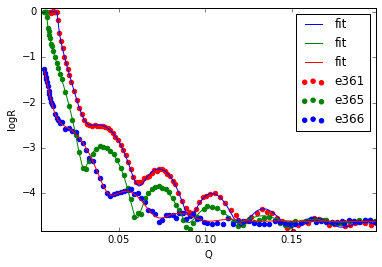

In [10]:
scatter(e361.x, e361.y, label='e361', color='r')
scatter(e365.x, e365.y, label='e365', color='g')
scatter(e366.x, e366.y, label='e366', color='b')

plot(e361.x, RFF.model(e361.x, res361.params, dqvals=e361.x_sd), label='fit')
plot(e365.x, RFF.model(e365.x, res365.params, dqvals=e365.x_sd), label='fit')
plot(e366.x, RFF.model(e366.x, res366.params, dqvals=e366.x_sd), label='fit')

ylim(np.min(e361.y), 0.1)
xlim(0.005, np.max(e361.x))
xlabel('Q')
ylabel('logR')
legend()

In [11]:
gfitter = GlobalFitter([fitter361, fitter365, fitter366],
                       constraints=['d1:thick1=d0:thick1',
                                    'd2:thick1=d0:thick1',
                                    'd1:thick2=d0:thick2',
                                    'd2:thick2=d0:thick2',
                                    'd1:SLD1=d0:SLD1',
                                    'd2:SLD1=d0:SLD1',
                                    'd1:sigma1=d0:sigma1',
                                    'd2:sigma1=d0:sigma1',
                                    'd1:sigma2=d0:sigma2',
                                    'd2:sigma2=d0:sigma2',
                                    'd1:sigma_back=d0:sigma_back',
                                    'd2:sigma_back=d0:sigma_back'
                                    ])

In [12]:
%time res_gemcee = gfitter.emcee(params=gfitter.params,nwalkers=200, steps=1000, burn=500, thin=10, workers=multiprocessing.cpu_count())

CPU times: user 2min 49s, sys: 1.56 s, total: 2min 50s
Wall time: 7min 39s


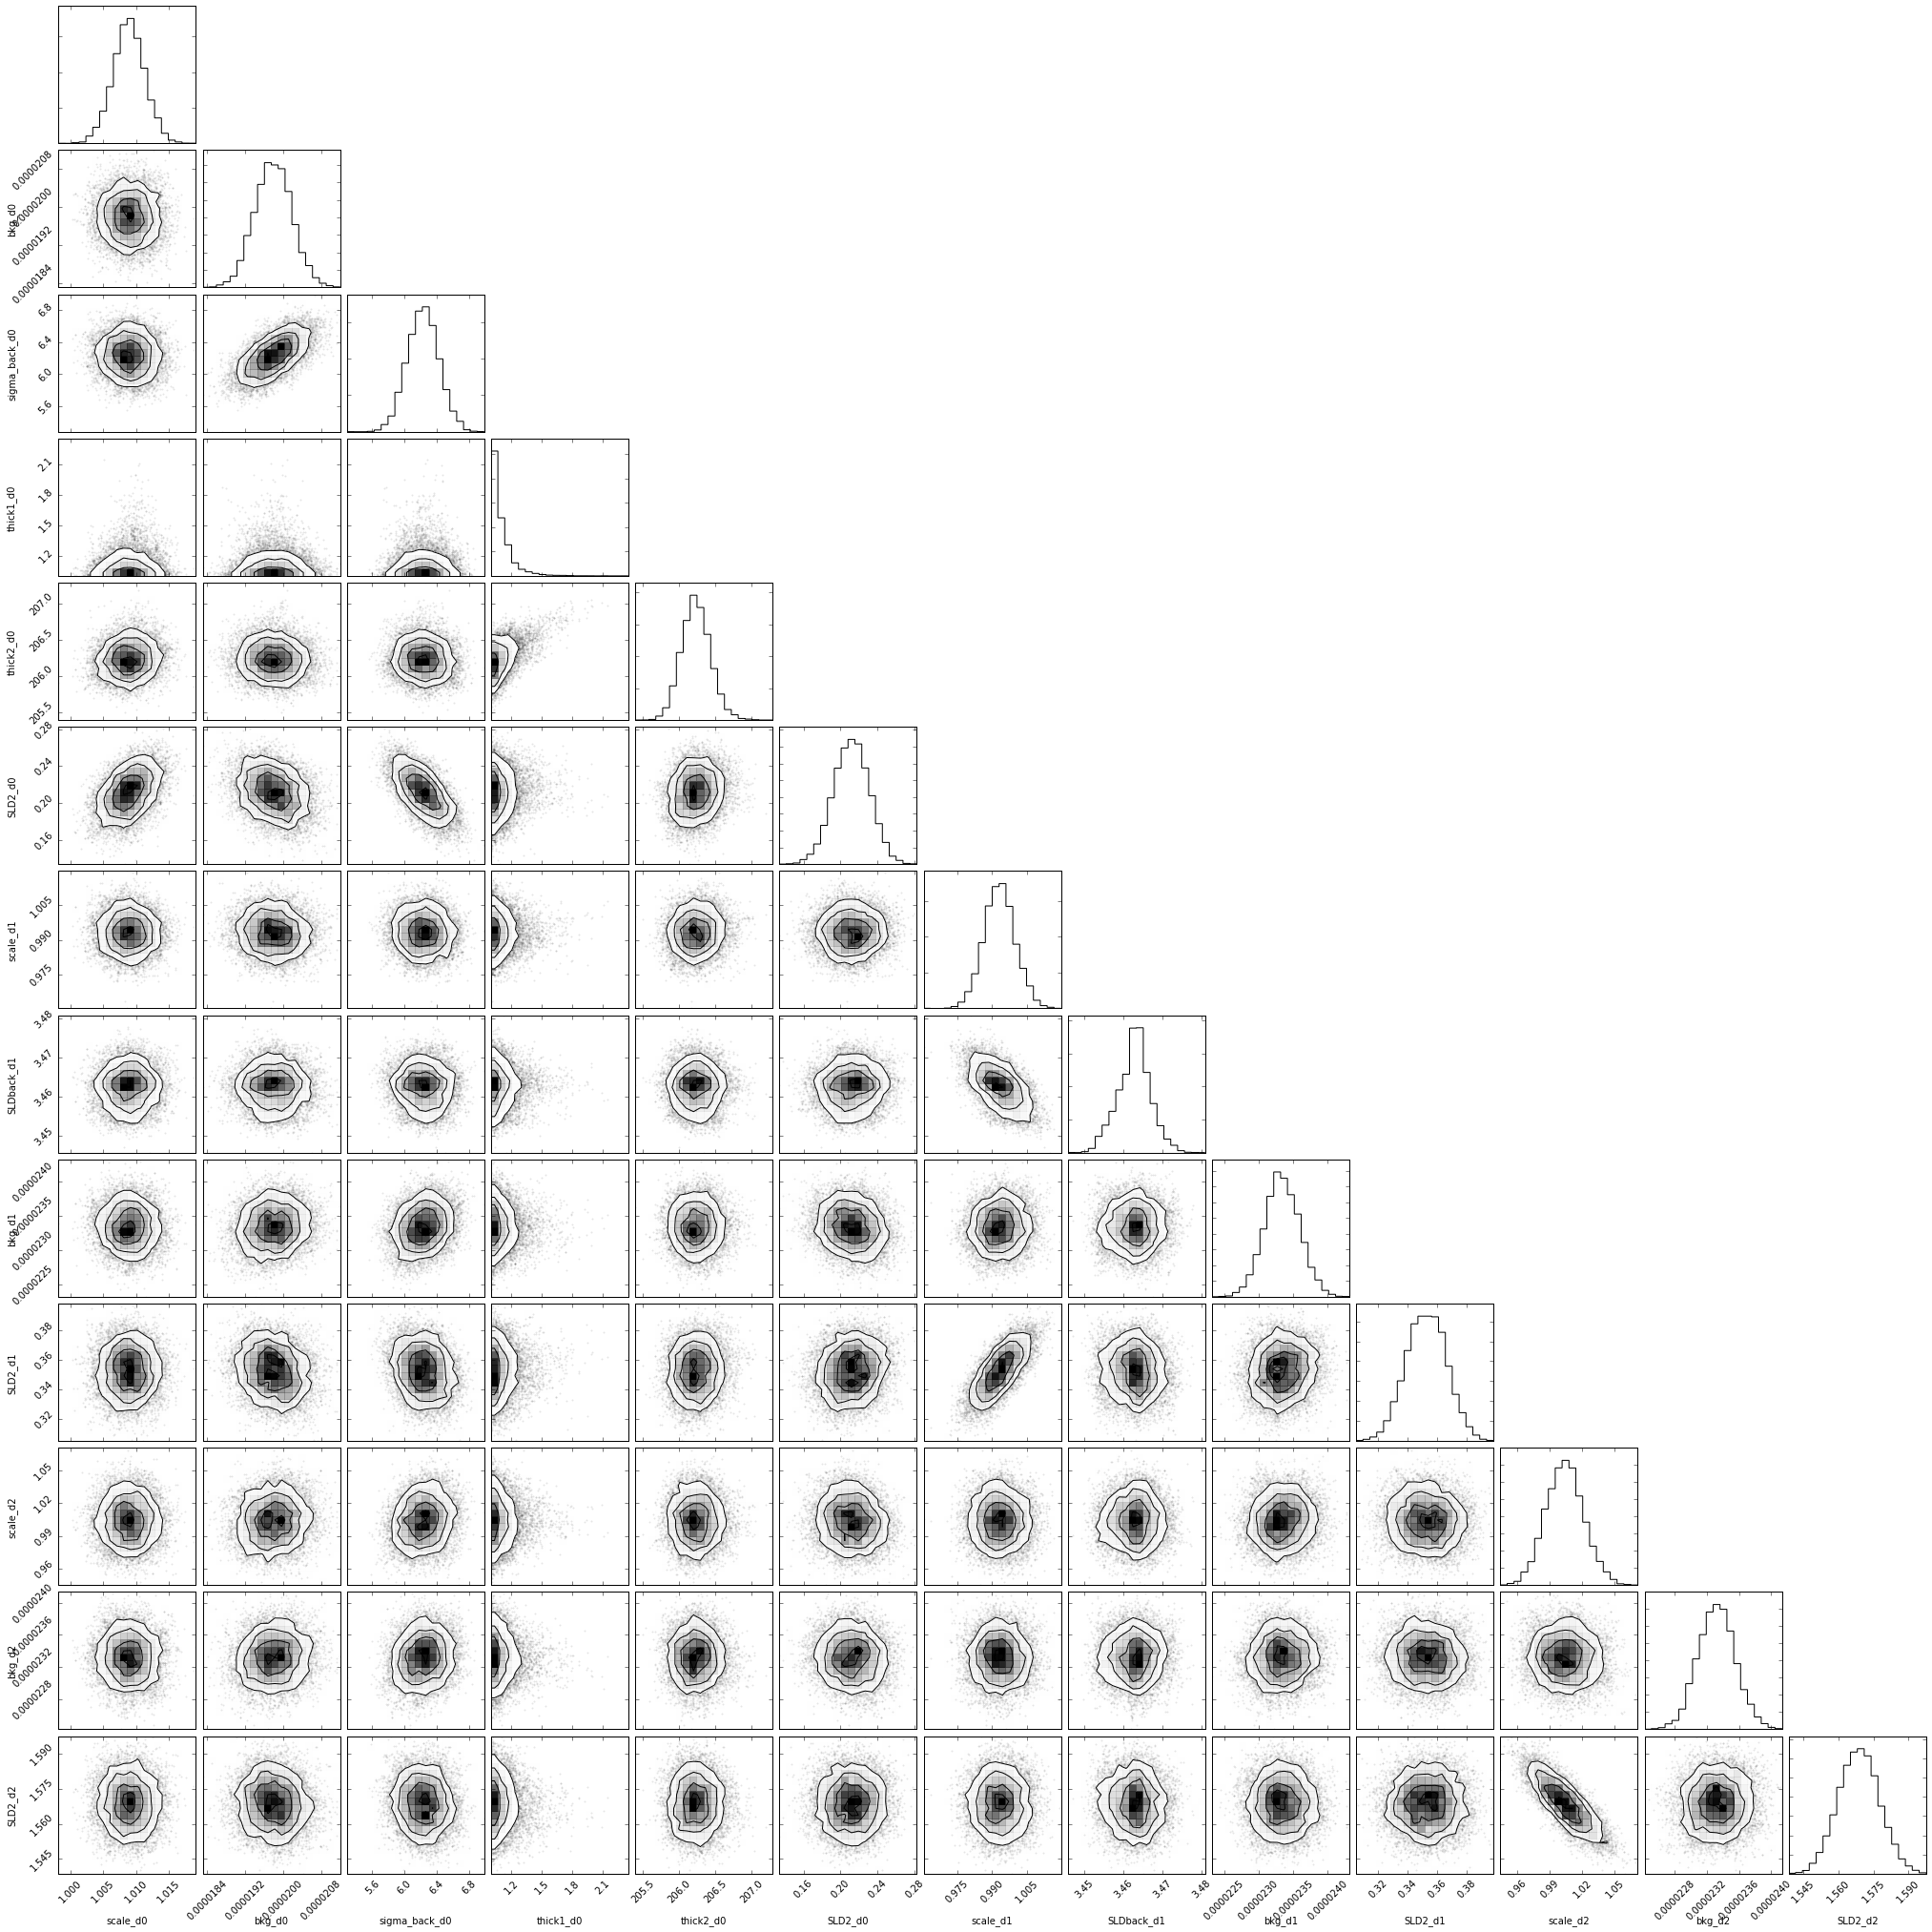

In [13]:
a = corner.corner(res_gemcee.flatchain)

In [14]:
def pgen(parameters, flatchain, idx=None):
    # generator for all the different parameters from a flatchain.
    if idx is None:
        idx = range(np.size(flatchain, 0))
    for i in idx:
        vec = flatchain.iloc[i]
        for var_name in flatchain.columns:
            parameters[var_name].value = flatchain.iloc[i][var_name]
        yield parameters

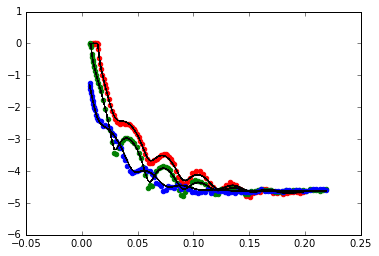

In [15]:
scatter(fitter361.xdata, fitter361.ydata, color='r')
scatter(fitter365.xdata, fitter365.ydata, color='g')
scatter(fitter366.xdata, fitter366.ydata, color='b')

for par in pgen(res_gemcee.params, res_gemcee.flatchain, idx=np.random.randint(len(res_gemcee.flatchain), size=500)):
    # have to call model() to redistribute the parameters to the original fitters.
    gfitter.model(par)
    plot(e361.x, fitter361.model(fitter361.params), color='black', alpha=0.01)
    plot(e365.x, fitter365.model(fitter365.params), color='black', alpha=0.01)
    plot(e366.x, fitter366.model(fitter366.params), color='black', alpha=0.01)